In [24]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import theilslopes
from collections import defaultdict
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import glob
from typing import Dict, Tuple, Any, Optional


# === CONFIG ===
PERIODS = {
    "1940-2020": (1940, 2020),
    "1940-1979": (1940, 1979),
    "1980-2020": (1980, 2020),
}

MODELS = [
    "ACCESS-ESM1-5", "CanESM5", "CMCC-CM2-SR5", 
    "HadGEM3-GC31-LL", "MIROC6", "MPI-ESM1-2-LR",
    "NorESM2-LM"
]

EXPERIMENTS = [
    "historical", "hist-GHG", "hist-aer", "hist-nat",
    "hist-sol", "hist-volc", "hist-totalO3"
]

BASE_FOLDER = "/gws/nopw/j04/aopp/tildah/HW_metrics/"

ERA5 = xr.open_dataset(os.path.join("~/Internship/model_map_creation/data/ERA5_historical_trends.nc"))
if ERA5['lat'][0] > ERA5['lat'][-1]:
    ERA5 = ERA5.sortby('lat')

ERA5_mask = xr.open_dataset('~/ERA5_lsm_NH.nc')
ERA5_mask = ERA5_mask.rename({
    "longitude": "lon",
    "latitude": "lat",
    "time": "valid_time"
})

ERA5_mask = ERA5_mask.sel(lon=slice(-25,45), lat=slice(72, 36))
ERA5_mask = ERA5_mask.interp(lat=ERA5['lat'], lon=ERA5['lon'], method='nearest')
land_mask_binary = xr.where(ERA5_mask > 0, 1, 0) 
lsm = land_mask_binary['lsm']

# === ERA5 PROCESSING ===
def load_era5(lat1, lat2):
    ERA5 = xr.open_dataset('/home/users/tildah/Internship/ERA5/ERA5_HWF_with2025.nc').sel(lat=slice(lat2, lat1))
    mask = xr.open_dataset('~/ERA5_lsm_NH.nc').rename({"longitude": "lon", "latitude": "lat"})
    mask = mask.sel(lon=slice(-25, 45), lat=slice(lat2, lat1))
    lsm = xr.where(mask > 0, 1, 0).interp_like(ERA5)['lsm']
    land = ERA5.where(lsm == 1)
    weights = np.cos(np.deg2rad(land.lat))
    return land['days'].weighted(weights).mean(dim=("lat", "lon"))

# === MODEL PROCESSING ===
def load_model_series(lat1, lat2):
    eu_avg_dict = {}
    for model in MODELS:
        mask = xr.open_dataset(f"{BASE_FOLDER}/lsms/sftlf_{model}.nc")['sftlf']
        land_mask = xr.where(mask > 0, 1, 0)
        
        for exp in EXPERIMENTS:
            folder = os.path.join(BASE_FOLDER, model, exp)
            try:
                files = [f for f in os.listdir(folder) if f.endswith(".nc")]
            except FileNotFoundError:
                print(f"Missing: {folder}")
                continue

            for file in files:
                member = file.split('_')[2]
                ds = xr.open_dataset(os.path.join(folder, file))
                ds = ds.sel(year = slice(1940, 2020)).sel(lat = slice(lat1, lat2))
                ds = ds.interp(lat=ERA5['lat'], lon=ERA5['lon'], method='nearest')
                masked = ds.where(lsm == 1).squeeze().drop_vars(['valid_time', 'height', 'quantile'], errors = "ignore")
                #masked['days'].sel(year = 2010).plot()
                weights = np.cos(np.deg2rad(masked.lat))
                eu_avg = masked['days'].weighted(weights).mean(dim=("lat", "lon"))
                eu_avg_dict[(model, exp, member)] = eu_avg

    series_dict = {}

    grouped = defaultdict(dict)
    for (model, exp, member), series in eu_avg_dict.items():
        grouped[(model, exp)][member] = series

    for (model, exp), members in grouped.items():
        series_dict[(model, exp)] = xr.concat(members.values(), dim='member').mean(dim='member')
    return series_dict


# === STATISTICS ===

def bootstrap_uncertainty(
    df: "pd.DataFrame",
    region: Optional[str],
    n_boot: int = 1000,
    ci: float = 95.0,
    rng_seed: Optional[int] = 42,
) -> Dict[Tuple[str, str], Dict[str, float]]:
    results: Dict[Tuple[str, str], Dict[str, float]] = {}

    # filter by region if requested
    df_region = df if region is None else df[df["region"] == region]
    rng = np.random.default_rng(rng_seed)

    # iterate experiments and periods (use keys from PERIODS)
    for exp in EXPERIMENTS:
        for period in PERIODS.keys():
            df_sub = df_region.loc[
                (df_region["experiment"] == exp) & (df_region["period"] == period)
            ]

            # Group values by model -> list/array of arrays
            grouped = df_sub.groupby("model")["value"].apply(lambda x: x.to_numpy(dtype=float))

            models = grouped.index.to_list()
            vals_per_model = [grouped.loc[m] for m in models]
            member_counts = [len(v) for v in vals_per_model]
            n_models = len(models)

            # Compute original per-model means, then MMM as mean across models (equal weighting)
            per_model_means = np.array([np.nanmean(v) for v in vals_per_model], dtype=float)
            original_mmm = np.nanmean(per_model_means)  # equal-weighted model mean

            # Bootstrap: resample within each model, compute sampled model means, then average across models
            boots = np.empty(n_boot, dtype=float)
            for i in range(n_boot):
                sampled_model_means = np.empty(n_models, dtype=float)
                for j, v in enumerate(vals_per_model):
                    n_i = len(v)
                    # sample indices 0..n_i-1 with replacement
                    draw = rng.integers(0, n_i, size=n_i)
                    sampled = v[draw]             # array of length n_i
                    sampled_model_means[j] = np.nanmean(sampled)
                # average the sampled per-model means (equal-weight across models)
                boots[i] = np.nanmean(sampled_model_means)

            # CI percentiles
            lower_p, upper_p = ((100.0 - ci) / 2.0, 100.0 - (100.0 - ci) / 2.0)
            lower, upper = np.percentile(boots, [lower_p, upper_p])

            results[(exp, period)] = {
                "mean": float(original_mmm),
                "lower": float(lower),
                "upper": float(upper),
            }

    return results


In [58]:
lat1 = 36
lat2 = 72
latmid = 50
region = 'Europe'

# === MAIN ===
ERA5_series = load_era5(lat1, lat2)
series_dict = load_model_series(lat1, lat2)


#df = pd.read_csv("regional_average_then_trends_withERA5.csv") NOT THIS ONE
df = pd.read_csv("trends_then_regional_average_withERA5.csv")
trends_df = df[df["region"] == region]

# Separate ERA5 rows from model ensemble rows
model_trends = trends_df[trends_df["model"] != "ERA5"].copy()
#print(model_trends)
ERA5_trends = trends_df[trends_df["model"] == "ERA5"].copy()
#gives MMM and CI
bootstrap_results = bootstrap_uncertainty(model_trends, region=None, n_boot=1000, ci=95.0)

In [65]:
ERA5_data = df[:9]
model_Europe = bootstrap_uncertainty(df[df["model"] != "ERA5"].copy(), region='Europe', n_boot=1000, ci=95.0)
model_South= bootstrap_uncertainty(df[df["model"] != "ERA5"].copy(), region='South', n_boot=1000, ci=95.0)
model_North= bootstrap_uncertainty(df[df["model"] != "ERA5"].copy(), region='North', n_boot=1000, ci=95.0)

In [69]:
for exp in EXPERIMENTS:
    print(exp)
    # map region name in ERA5_data to the corresponding model dict you have
    model_map = {
        "Europe": model_Europe,
        "North": model_North,
        "South": model_South,
    }
    
    def get_historical_entry(model_dict, period):
        key1 = (exp, period)
        return model_dict[key1]
    
    # build rows by iterating ERA5_data rows (assumes ERA5_data is a pandas DataFrame)
    rows = []
    for idx, row in ERA5_data.iterrows():
        region = row['region']
        period = row['period']
        era5_val = row['value']  # adjust if ERA5_data uses a different column name
    
        model_dict = model_map.get(region)
        if model_dict is None:
            # unknown region - still append with NaNs
            rows.append({
                "region": region,
                "period": period,
                "ERA5_value": era5_val,
                f"{exp}_MMM": np.nan,
                "half_width": np.nan,
            })
            continue
    
        entry = get_historical_entry(model_dict, period)
        mmm = entry.get('mean', np.nan)
        lower = entry.get('lower', np.nan)
        upper = entry.get('upper', np.nan)
        # compute half width robustly (if bounds exist)
        if pd.isna(lower) or pd.isna(upper):
            half_width = np.nan
        else:
            half_width = (upper - lower) / 2.0

        if period == "1940-1979":
            rows.append({
                "region": region,
                "period": period,
                "ERA5_value": era5_val,
                f"{exp}_MMM": mmm,
                "half_width": half_width,
            })
    
    # create DataFrame
    result_df = pd.DataFrame(rows, columns=["region", "period", "ERA5_value", f"{exp}_MMM", "half_width"])
    
    # (optional) reorder/sort in a predictable way: by region then period
    period_order = ["1940-1979", "1980-2020", "1940-2020"]
    result_df['period'] = pd.Categorical(result_df['period'], categories=period_order, ordered=True)
    result_df = result_df.sort_values(['region', 'period']).reset_index(drop=True)
    
    # show result
    print(result_df)
   

historical
   region     period  ERA5_value  historical_MMM  half_width
0  Europe  1940-1979    -0.03117       -0.061650    0.010795
1   North  1940-1979     0.02410       -0.046669    0.012883
2   South  1940-1979    -0.08450       -0.076150    0.012417
hist-GHG
   region     period  ERA5_value  hist-GHG_MMM  half_width
0  Europe  1940-1979    -0.03117      0.043321    0.010689
1   North  1940-1979     0.02410      0.047917    0.016471
2   South  1940-1979    -0.08450      0.038472    0.009503
hist-aer
   region     period  ERA5_value  hist-aer_MMM  half_width
0  Europe  1940-1979    -0.03117     -0.469098    0.046304
1   North  1940-1979     0.02410     -0.357888    0.056268
2   South  1940-1979    -0.08450     -0.574636    0.056937
hist-nat
   region     period  ERA5_value  hist-nat_MMM  half_width
0  Europe  1940-1979    -0.03117     -0.078674    0.022116
1   North  1940-1979     0.02410     -0.055668    0.027549
2   South  1940-1979    -0.08450     -0.102125    0.032799
hist-sol
 

In [39]:
#THIS GETS TRENDS FOR EACH MODEL.
# -------- Collect ensemble members into mean_trends ----------
mean_trends = defaultdict(list)
# model_trends rows hold member-level values
for _, row in model_trends.iterrows():
    model = row["model"]
    exp = row["experiment"]
    member = row.get("member", None)
    p = row["period"]
    val = row["value"]
    if not np.isnan(val):
        mean_trends[(model, exp, p)].append(val)

In [40]:
#TABLE OF BAR PLOT CONTENT
df_boots = pd.DataFrame.from_dict(bootstrap_results, orient='index').reset_index()
df_boots.columns = ['experiment', 'period', 'MMM', 'lower', 'upper']

df_wide = df_models.pivot_table(
    index=['experiment', 'period'],
    columns='model',
    values='model_mean',
    aggfunc='first'   # each (exp,period,model) should be unique; 'first' is safe
)

# The pivot_table result has a MultiIndex columns (models). Flatten columns and rename:
df_wide = df_wide.rename_axis(columns=None).reset_index()
# Optionally prefix model columns to make clear they're model means:
model_cols = [c for c in df_wide.columns if c not in ('experiment', 'period')]
df_wide = df_wide.rename(columns={c: f"{c}" for c in model_cols})

df_final = df_boots.merge(df_wide, on=['experiment', 'period'], how='left')
print(df_final)
#df_final.to_csv(f'HWF_{region}_trends_3.11.25.csv', index=False)

      experiment     period       MMM     lower     upper  ACCESS-ESM1-5  \
0     historical  1940-2020  0.822320  0.801969  0.844981       0.389008   
1     historical  1940-1979 -0.271884 -0.311065 -0.235121      -0.157947   
2     historical  1980-2020  2.484013  2.412193  2.551135       2.616500   
3       hist-GHG  1940-2020  0.830281  0.808560  0.852361       0.381410   
4       hist-GHG  1940-1979  0.348194  0.294286  0.404236       0.066237   
5       hist-GHG  1980-2020  1.334157  1.229473  1.441730       0.958687   
6       hist-aer  1940-2020 -0.139808 -0.167187 -0.112240       0.013214   
7       hist-aer  1940-1979 -0.937241 -1.009577 -0.859507      -0.579410   
8       hist-aer  1980-2020  0.573925  0.508457  0.644591       0.713120   
9       hist-nat  1940-2020 -0.053245 -0.080440 -0.028886      -0.006832   
10      hist-nat  1940-1979 -0.222124 -0.288174 -0.159158      -0.113556   
11      hist-nat  1980-2020  0.239277  0.185017  0.295180       0.099140   
12      hist

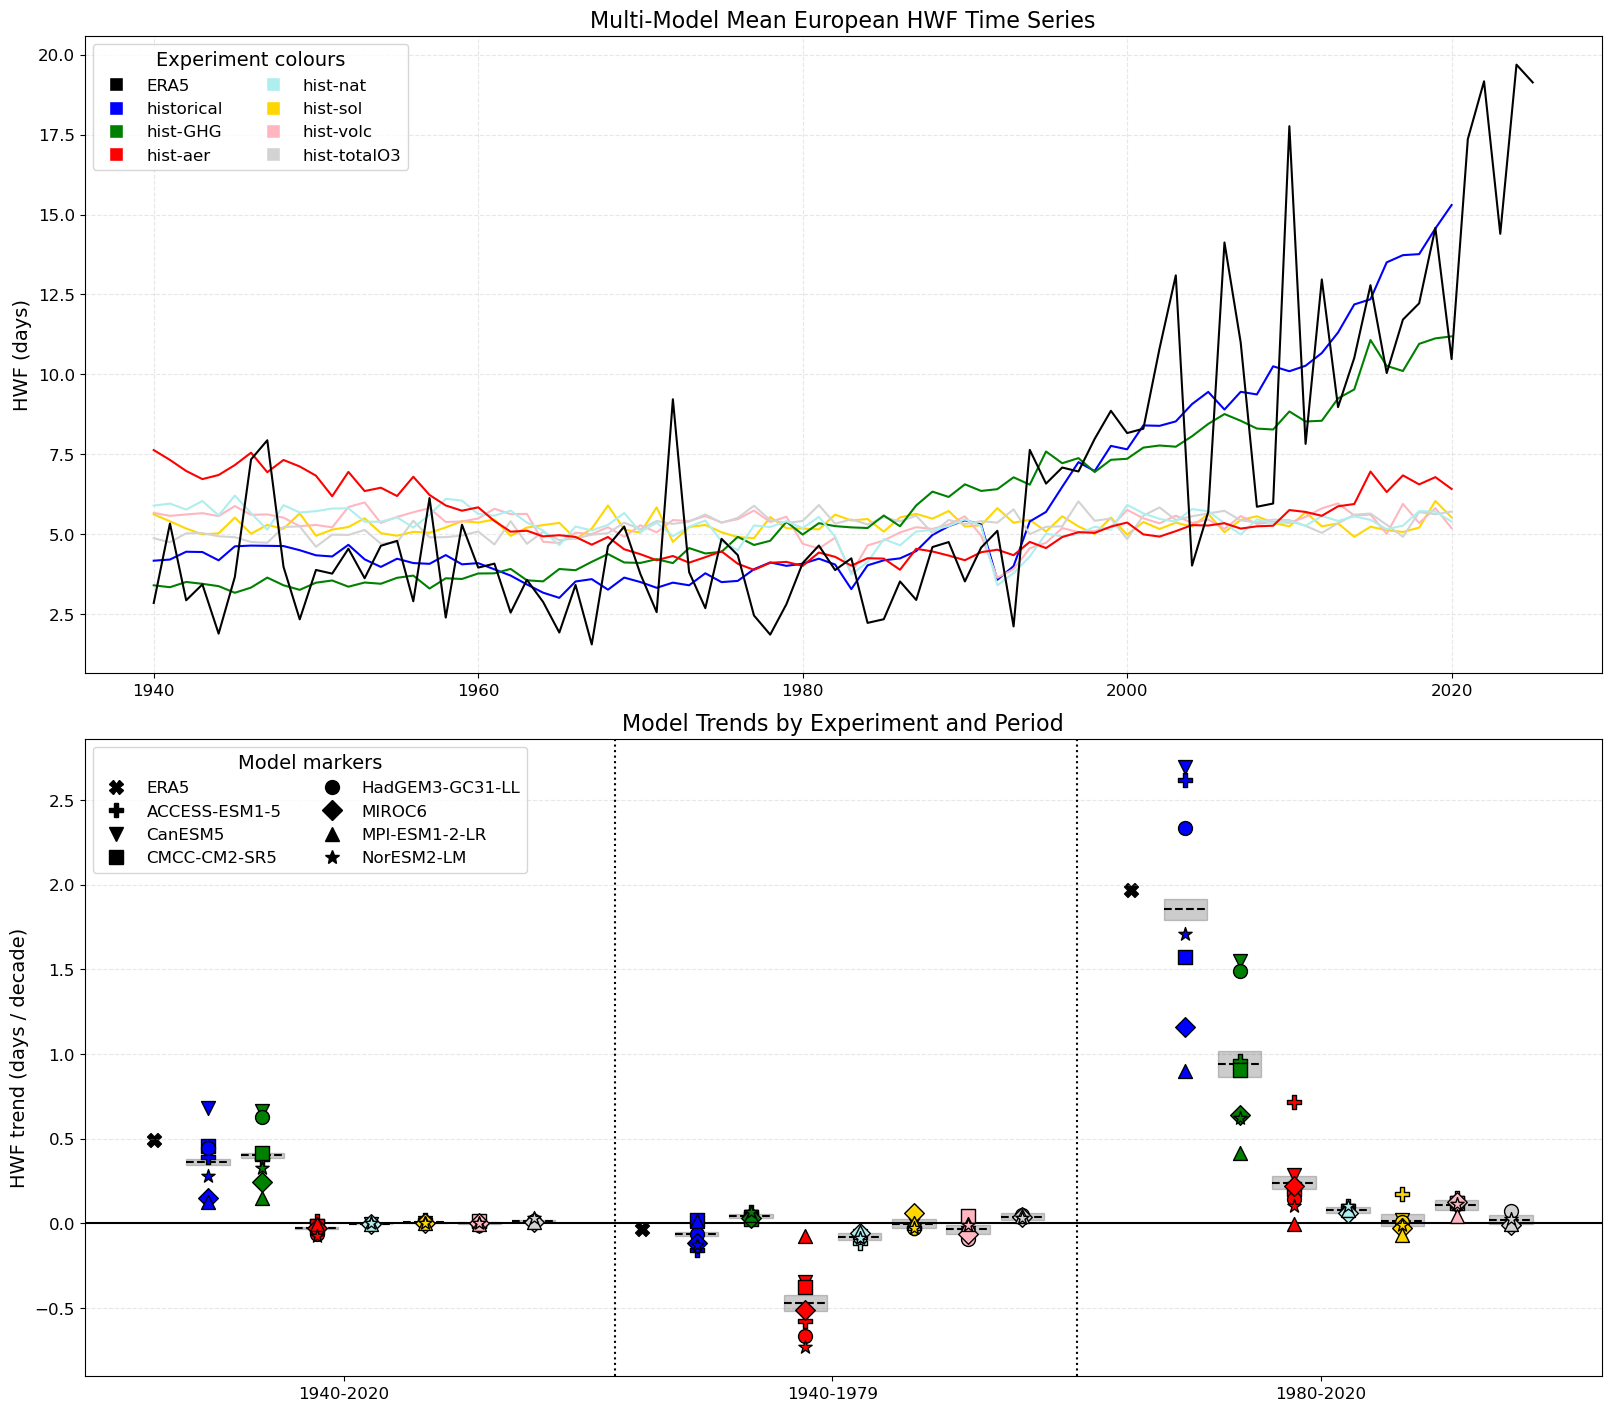

In [29]:
show_members = False
add_mmm_ci = True

COLORS = {
    "ERA5": "black", "historical": "blue", "hist-GHG": "green", 
    "hist-aer": "red", "hist-nat": "paleturquoise", "hist-totalO3": "lightgrey",
    "hist-volc": "lightpink", "hist-sol": "gold"
}

MARKERS = {
    "HadGEM3-GC31-LL": "o", "ERA5": "X", "CMCC-CM2-SR5": "s",
    "MPI-ESM1-2-LR": "^", "MIROC6": "D", "CanESM5": "v",
    "ACCESS-ESM1-5": "P", "NorESM2-LM": "*"
}

PLOT_STYLE = {
    "figsize": (16, 14),
    "title_size": 16,
    "label_size": 14,
    "tick_size": 12,
    "legend_size": 12,
}

periods = list(PERIODS)
fig, axes = plt.subplots(2, 1, figsize=PLOT_STYLE["figsize"], constrained_layout=True)

# Legends
model_legend = [Line2D([0], [0], marker=MARKERS[m], color="w", label=m,
                       markerfacecolor="black", markeredgecolor="black",
                      markersize = 10)
                for m in ["ERA5"]+MODELS if m in MARKERS]
exp_legend = [Line2D([0], [0], marker="s", color="w", label=e,
                     markerfacecolor=COLORS.get(e, "k"),
                    markersize = 10)
              for e in ["ERA5"] + EXPERIMENTS]

mean_legend = [Line2D([0], [0], ls="--", c="black", label="MMM (bootstrapped)")]


# === UPPER PANEL: Time Series ===
ax = axes[0]
for exp in {exp for _, exp in series_dict}:
    ts_list = [ts.to_series() for (m, e), ts in series_dict.items() if e == exp]
    if ts_list:
        mean_ts = pd.concat(ts_list, axis=1).mean(axis=1)

        ax.plot(mean_ts.index, mean_ts, label=exp, color=COLORS.get(exp, "black"))

ax.plot(ERA5_series.year, ERA5_series, label="ERA5", color="black")
#ax.set_xlabel("Year", fontsize=PLOT_STYLE["label_size"])
ax.set_ylabel("HWF (days)", fontsize=PLOT_STYLE["label_size"])
ax.set_title("Multi-Model Mean European HWF Time Series", fontsize=PLOT_STYLE["title_size"])
ax.tick_params(axis="both", labelsize=PLOT_STYLE["tick_size"])
ax.grid(ls="--", alpha=0.3)
#ax.legend(fontsize=PLOT_STYLE["legend_size"], loc="best")
ax.legend(handles=exp_legend,
                 fontsize=PLOT_STYLE["legend_size"],
                 title="Experiment colours",
                 title_fontsize=PLOT_STYLE["label_size"],
                 loc="best", ncol=2)


# === RIGHT PANEL: Trends ===
ax = axes[1]
x_map, centers = {}, []
for i, p in enumerate(periods):
    order = ["ERA5"] + EXPERIMENTS
    start = i * (len(order) + 1)
    centers.append(start + (len(order) - 1) / 2)
    for j, exp in enumerate(order):
        x_map[(exp, p)] = start + j


# -------- Scatter all members (model ensemble members) ----------
if show_members:
    # iterate rows in model_trends (each row is one member)
    for _, row in model_trends.iterrows():
        model = row["model"]
        exp = row["experiment"]
        p = row["period"]
        val = row["value"]
        if not np.isnan(val):
            ax.scatter(
                x_map[(exp, p)],
                val,
                marker=MARKERS.get(model, "o"),
                color=COLORS.get(exp, "black"),
                alpha=0.2,
                edgecolor="black",
                s=50,
            )

# -------- Collect ensemble members into mean_trends ----------
mean_trends = defaultdict(list)
# model_trends rows hold member-level values
for _, row in model_trends.iterrows():
    model = row["model"]
    exp = row["experiment"]
    member = row.get("member", None)
    p = row["period"]
    val = row["value"]
    if not np.isnan(val):
        mean_trends[(model, exp, p)].append(val)

# -------- Ensemble means (one dot per model) ----------
for (model, exp, p), vals in mean_trends.items():
    y = float(np.mean(vals))
    ax.scatter(
        x_map[(exp, p)],
        y,
        marker=MARKERS.get(model, "o"),
        color=COLORS.get(exp, "black"),
        edgecolor="black",
        s=100,
        zorder=5,
    )

# -------- Add ERA5 (one dot per period) ----------
era5_by_period = ERA5_trends.groupby("period")["value"].mean().to_dict()
for p, val in era5_by_period.items():
    ax.scatter(x_map[("ERA5", p)], val, marker=MARKERS["ERA5"],
               color="black", edgecolor="black", s=100)

# -------- MMM (multi-model mean ± CI) ----------
for (exp, p), stats in bootstrap_results.items():
    xpos = x_map[(exp, p)]
    if np.isnan(stats["mean"]):
        continue
    # dashed horizontal line for MMM
    ax.hlines(stats["mean"], xpos - 0.4, xpos + 0.4, colors="black", ls="--", lw=1.5, zorder=3)
    # optional shaded CI band
    if add_mmm_ci:
        lower, upper = stats["lower"], stats["upper"]
        ax.fill_between([xpos - 0.4, xpos + 0.4], [lower, lower], [upper, upper], color="black", alpha=0.2, zorder=2)

ax.axhline(0, c="k", lw=1.5)
for i in range(1, len(periods)):
    ax.axvline(i*(len(EXPERIMENTS)+1.5), c="k", ls=":")

ax.set_xticks(centers, periods, fontsize=PLOT_STYLE["tick_size"])
ax.set_ylabel("HWF trend (days / decade)", fontsize=PLOT_STYLE["label_size"])
ax.set_title("Model Trends by Experiment and Period", fontsize=PLOT_STYLE["title_size"])
ax.tick_params(axis="both", labelsize=PLOT_STYLE["tick_size"])
ax.grid(axis="y", ls="--", alpha=0.3)

# First legend: experiment colours
"""exp_leg = fig.legend(handles=exp_legend,
                     fontsize=PLOT_STYLE["legend_size"],
                     title="Experiment colours",
                     title_fontsize=PLOT_STYLE["label_size"],
                     loc="lower center", ncol=1, bbox_to_anchor=(0.25, -0.07))"""

# Second legend: model markers
ax.legend(handles=model_legend,
                       fontsize=PLOT_STYLE["legend_size"],
                       title="Model markers",
                       title_fontsize=PLOT_STYLE["label_size"],
                       loc="upper left", ncol=2)
plt.savefig('HWF_timeseries_and_trends_3.11.2025.png')
plt.show()


In [6]:
# === AVERAGE HWF + MMM with bootstrap ===
# average number of heatwave days per year 
def compute_mean_hwf_and_mmm(ERA5_series, model_series, n_boot=10000, ci=95):
    results = {}

    # ERA5 mean (1940–2020)
    ERA5_mean = ERA5_series.sel(year=slice(1940, 2020)).mean().item()
    results["ERA5"] = ERA5_mean

    # Models (historical experiment only)
    per_member_means = []
    model_means = defaultdict(list)
 
    for (model, exp, member), series in model_series.items():
        if exp == "historical":
            val = series.sel(year=slice(1940, 2020)).mean().item()
            model_means[model].append(val)
            per_member_means.append(val)

    # Ensemble mean per model
    results["models"] = {m: np.mean(vals) for m, vals in model_means.items()}

    # MMM via bootstrap across all members
    per_member_means = np.array(per_member_means)
    boots = [np.mean(np.random.choice(per_member_means,
                                      size=len(per_member_means),
                                      replace=True))
             for _ in range(n_boot)]
    mean = np.mean(boots)
    lower, upper = np.percentile(boots, [(100-ci)/2, 100-(100-ci)/2])

    results["MMM"] = {"mean": mean, "lower": lower, "upper": upper}

    return results


mean_hwf_results = compute_mean_hwf_and_mmm(ERA5_series, model_series)

print("=== Mean HWF (1940–2020) ===")
print(f"ERA5: {mean_hwf_results['ERA5']:.2f}")
for model, val in mean_hwf_results["models"].items():
    print(f"{model}: {val:.2f}")
print("\n=== Multi-Model Mean (Historical) ===")
print(f"MMM: {mean_hwf_results['MMM']['mean']:.2f} "
      f"[{mean_hwf_results['MMM']['lower']:.2f}, "
      f"{mean_hwf_results['MMM']['upper']:.2f}]")
mmm = mean_hwf_results["MMM"]
print(f"MMM: {mmm['mean']:.2f} ± {(mmm['upper'] - mmm['lower'])/2:.2f}")

=== Mean HWF (1940–2020) ===
ERA5: 5.81
ACCESS-ESM1-5: 6.44
CanESM5: 6.26
CMCC-CM2-SR5: 5.40
HadGEM3-GC31-LL: 6.14
MIROC6: 5.34
MPI-ESM1-2-LR: 5.57
NorESM2-LM: 5.65

=== Multi-Model Mean (Historical) ===
MMM: 5.84 [5.79, 5.89]
MMM: 5.84 ± 0.05


In [7]:
# === INTERANNUAL VARIABILITY (with MMM) ===
def compute_interannual_variability(ERA5_series, model_series, n_boot=10000, ci=95):
    results = {}

    # ERA5: std over annual values
    ERA5_std = ERA5_series.sel(year=slice(1940, 2020)).std().item()
    results["ERA5"] = ERA5_std

    # Models: compute std per member
    grouped = defaultdict(list)
    all_hist_member_stds = []  # collect all historical member stds for MMM

    for (model, exp, member), series in model_series.items():
        vals = series.sel(year=slice(1940, 2020)).values
        std_val = np.std(vals, ddof=1)
        grouped[(model, exp)].append(std_val)
        if exp == "historical":
            all_hist_member_stds.append(std_val)

    # For each model/exp: average & CI across members
    for (model, exp), vals in grouped.items():
        vals = np.array(vals)
        if len(vals) == 0:
            results[(model, exp)] = {"mean": np.nan, "lower": np.nan, "upper": np.nan}
            continue

        boots = [np.mean(np.random.choice(vals, size=len(vals), replace=True)) for _ in range(n_boot)]
        lower, upper = np.percentile(boots, [(100-ci)/2, 100-(100-ci)/2])
        results[(model, exp)] = {"mean": np.mean(vals), "lower": lower, "upper": upper}

    # MMM for historical (bootstrapping over all ensemble members)
    all_hist_member_stds = np.array(all_hist_member_stds)
    if len(all_hist_member_stds) > 0:
        boots = [np.mean(np.random.choice(all_hist_member_stds,
                                          size=len(all_hist_member_stds),
                                          replace=True))
                 for _ in range(n_boot)]
        mean = np.mean(boots)
        lower, upper = np.percentile(boots, [(100-ci)/2, 100-(100-ci)/2])
        results["MMM-historical"] = {"mean": mean, "lower": lower, "upper": upper}
    else:
        results["MMM-historical"] = {"mean": np.nan, "lower": np.nan, "upper": np.nan}

    return results


interannual_var_results = compute_interannual_variability(ERA5_series, model_series)

print("\n=== Interannual Variability ===")
print(f"ERA5: {interannual_var_results['ERA5']:.2f}")
mean_vals = []
for key, d in interannual_var_results.items():
    if isinstance(key, tuple):  # model, exp pairs
        model, exp = key
        if exp == "historical":
            print(f"{model}-{exp}: {d['mean']:.2f} ± {(d['upper']-d['lower'])/2:.2f}")
            mean_vals.append(d['mean'])
mean = np.mean(mean_vals)
print(f"MMM (historical, mean): {mean}")
print(f"MMM (historical, bootstrapped): {interannual_var_results['MMM-historical']['mean']:.2f} ± "
      f"{(interannual_var_results['MMM-historical']['upper'] - interannual_var_results['MMM-historical']['lower'])/2:.2f}")


=== Interannual Variability ===
ERA5: 3.53
ACCESS-ESM1-5-historical: 4.89 ± 0.20
CanESM5-historical: 4.72 ± 0.11
CMCC-CM2-SR5-historical: 3.76 ± 0.18
HadGEM3-GC31-LL-historical: 4.26 ± 0.12
MIROC6-historical: 2.76 ± 0.08
MPI-ESM1-2-LR-historical: 3.20 ± 0.08
NorESM2-LM-historical: 3.74 ± 0.13
MMM (historical, mean): 3.9038110184195745
MMM (historical, bootstrapped): 3.82 ± 0.10


In [46]:
# === PERCENTAGES ====

def compute_percentage_contributions_with_total(bootstrap_results, historical_exp="historical", digits=2):
    # Collect historical means per period
    hist_means = {period: bootstrap_results[(historical_exp, period)]["mean"] 
                  for period in ["1940-1979", "1940-2020", "1980-2020"]}

    rows = []
    for (exp, period), stats in bootstrap_results.items():
        if exp == historical_exp:
            continue  # skip historical itself
        if period not in hist_means:
            continue
        perc = (stats["mean"] / hist_means[period]) * 100
        rows.append({
            "Experiment": exp,
            "Period": period,
            "Contribution (%)": perc
        })

    df = pd.DataFrame(rows)
    table = df.pivot(index="Experiment", columns="Period", values="Contribution (%)")

    # Add total row
    total_row = table.sum(axis=0)
    total_row.name = "Total"
    table = pd.concat([table, total_row.to_frame().T])

    # Round for display
    table = table.round(digits)

    return table

# Usage
contrib_table = compute_percentage_contributions_with_total(bootstrap_results)
print(contrib_table)

Period        1940-1979  1940-2020  1980-2020
hist-GHG         -70.27     111.39      50.64
hist-aer         760.91      -8.00      12.80
hist-nat         127.61      -1.18       4.25
hist-sol           2.99       1.36       0.87
hist-totalO3     -63.74       3.89       1.15
hist-volc         58.56       0.02       5.85
Total            816.06     107.49      75.55
